# ✨ Overview of the Dataset ✨

In previous research on sarcasm detection, Twitter datasets were commonly used, relying on hashtag-based supervision for data collection. However, these datasets often contain noise in both labels and language. Additionally, many tweets are responses to other tweets, requiring contextual information to accurately detect sarcasm.

To address these challenges, this **News Headlines Dataset** was curated specifically for sarcasm detection. Headlines were gathered from two distinct news sources. The first source, **The Onion**, is well-known for crafting sarcastic takes on current events. Headlines from their *News in Brief* and *News in Photos* sections were selected for their sarcastic nature. In contrast, non-sarcastic headlines were obtained from **HuffPost**, ensuring a balanced representation of genuine news.

This dataset comprises approximately **28,000 text samples**, each categorized into one of two classes: **Sarcastic** or **Non-Sarcastic**.

In this notebook, we will explore and analyze this dataset using two powerful embedding techniques: **Word2Vec** and **GloVe Embeddings**. After training models based on these embeddings, we will compare their performance to determine the superior approach. Let's dive in and uncover the story behind the data! 🚀


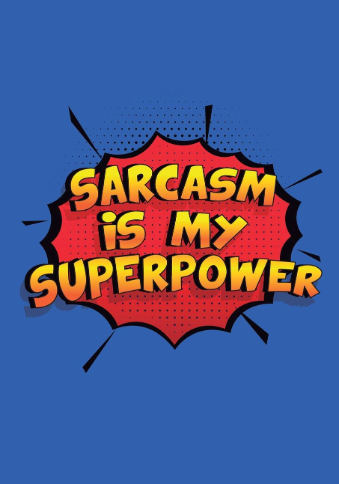

# Import the Libraries

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

# Load the Dataset

In [63]:
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)

# Data Preprocessing

In [64]:
df0 = df.copy()

In [65]:
df.head()

is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...

In [66]:
df.tail()

is_sarcastic                                           headline  \
28614             1       jews to celebrate rosh hashasha or something   
28615             1  internal affairs investigator disappointed con...   
28616             0  the most beautiful acceptance speech this week...   
28617             1  mars probe destroyed by orbiting spielberg-gat...   
28618             1                 dad clarifies this not a food stop   

                                            article_link  
28614  https://www.theonion.com/jews-to-celebrate-ros...  
28615  https://local.theonion.com/internal-affairs-in...  
28616  https://www.huffingtonpost.com/entry/andrew-ah...  
28617  https://www.theonion.com/mars-probe-destroyed-...  
28618  https://www.theonion.com/dad-clarifies-this-no...

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [68]:
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [69]:
df.drop("article_link", axis=1, inplace= True) # Deleting this column as it is of no use
df.head()

is_sarcastic                                           headline
0             1  thirtysomething scientists unveil doomsday clo...
1             0  dem rep. totally nails why congress is falling...
2             0  eat your veggies: 9 deliciously different recipes
3             1  inclement weather prevents liar from getting t...
4             1  mother comes pretty close to using word 'strea...

In [70]:
df.duplicated().sum()

116

In [71]:
# drop duplicated values from the dataset

df.drop_duplicates(inplace = True)

In [72]:
df.duplicated().sum()

0

In [73]:
df.is_sarcastic.value_counts()

is_sarcastic
0    14951
1    13552
Name: count, dtype: int64

In [74]:
#change all capital letters to small letters

from termcolor import colored

df["headline"] = df["headline"].apply(lambda x: " ".join(x.lower() for x in x.split()))


In [75]:
#remove all punctuation characters

df["headline"] = df["headline"].str.replace('[^\w\s]','')


In [76]:
#delete numbers

df["headline"] = df["headline"].str.replace('\d','')


In [77]:
#delete stopwords

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords

sw = stopwords.words("english")
df["headline"] = df["headline"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
#lemmatization. That is, we get the roots of the words

import nltk
nltk.download("wordnet")

from textblob import Word

df["headline"] = df["headline"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


MissingCorpusError: 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.


## Train and Test Split

In [79]:
X = df.headline
y = df.is_sarcastic

In [80]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Data Visualization

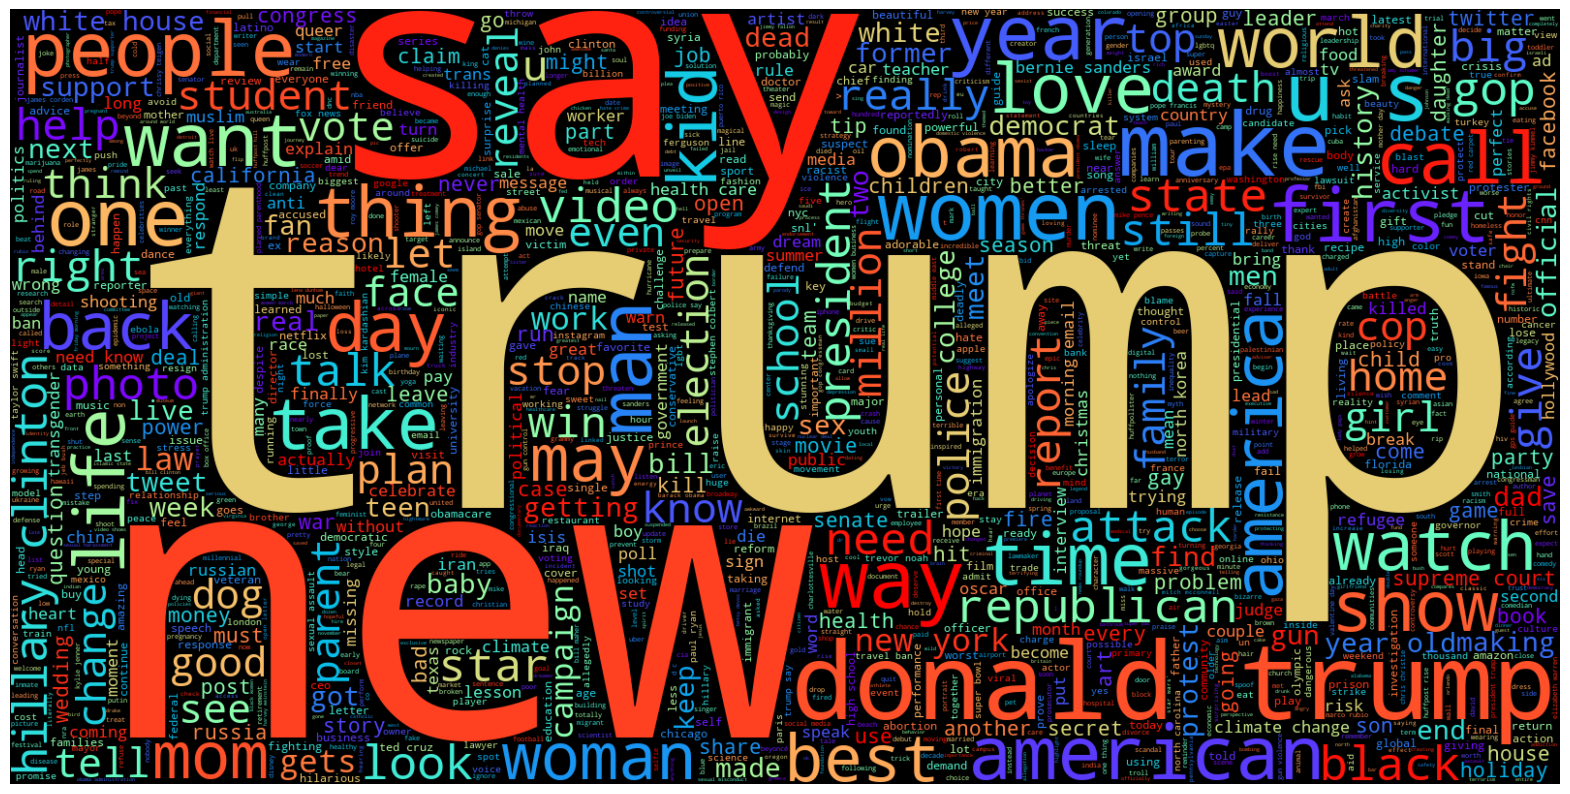

In [81]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize=(20, 20)) # Text that is Not Sarcastic
wc = WordCloud(
    max_words=2000,
    width=1600,
    height=800,
    colormap="rainbow"  
).generate(" ".join(df[df.is_sarcastic == 0].headline))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")  
plt.show()


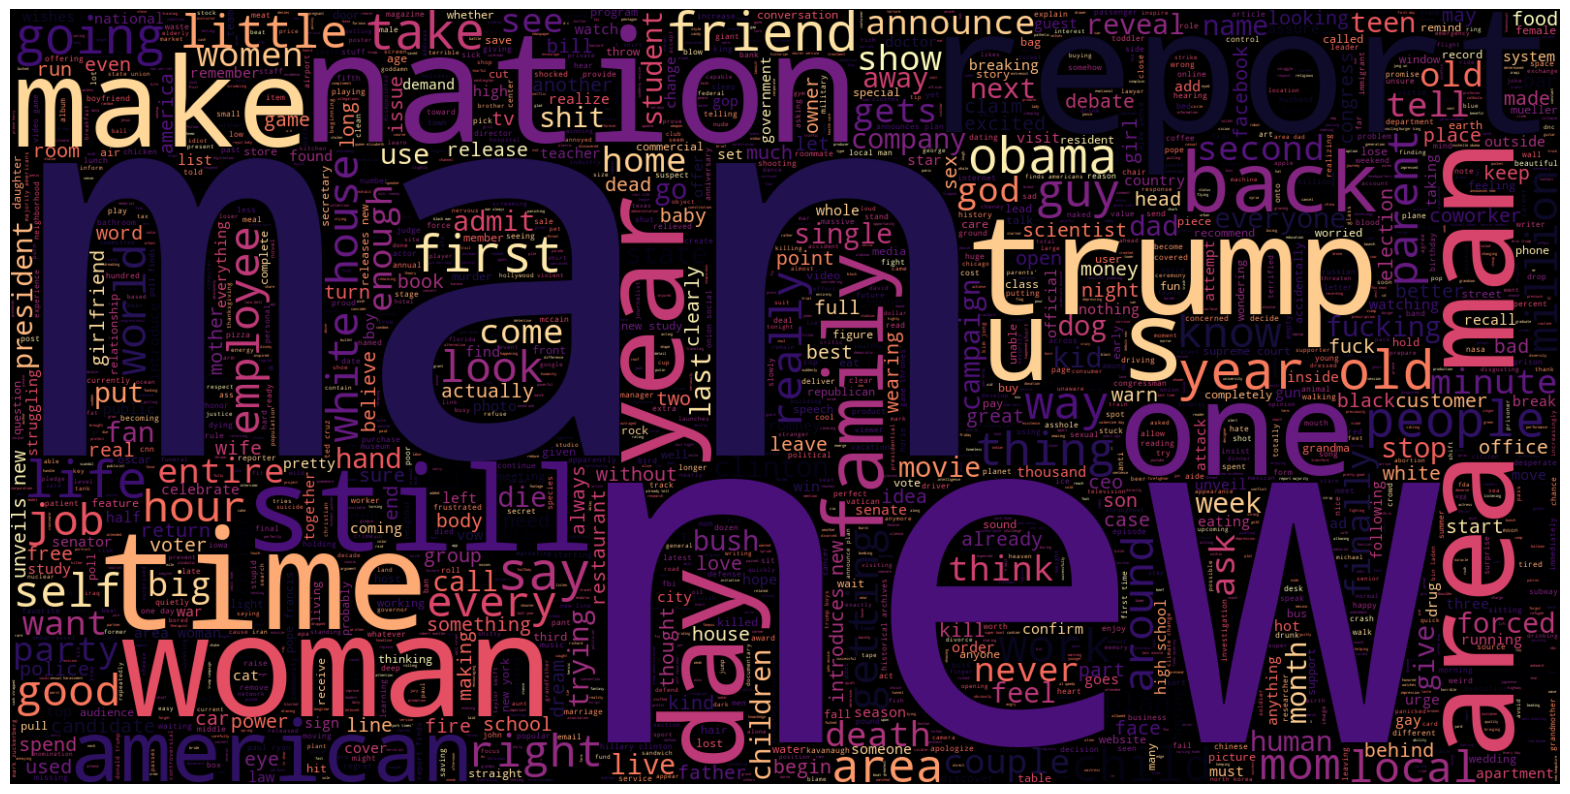

In [82]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize=(20, 20)) # Text that is Sarcastic
wc = WordCloud(
    max_words=2000,
    width=1600,
    height=800,
    colormap="magma"  
).generate(" ".join(df[df.is_sarcastic == 1].headline))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")  
plt.show()

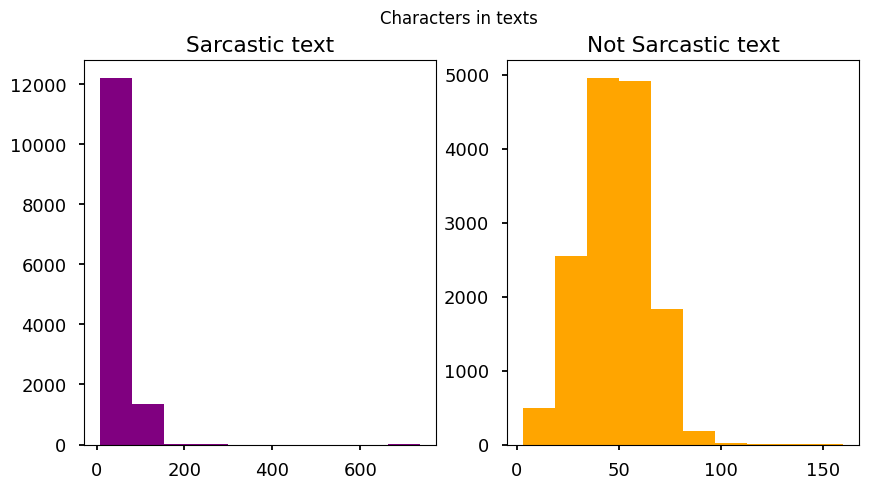

In [83]:
# Number of characters in texts

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='purple')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='orange')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

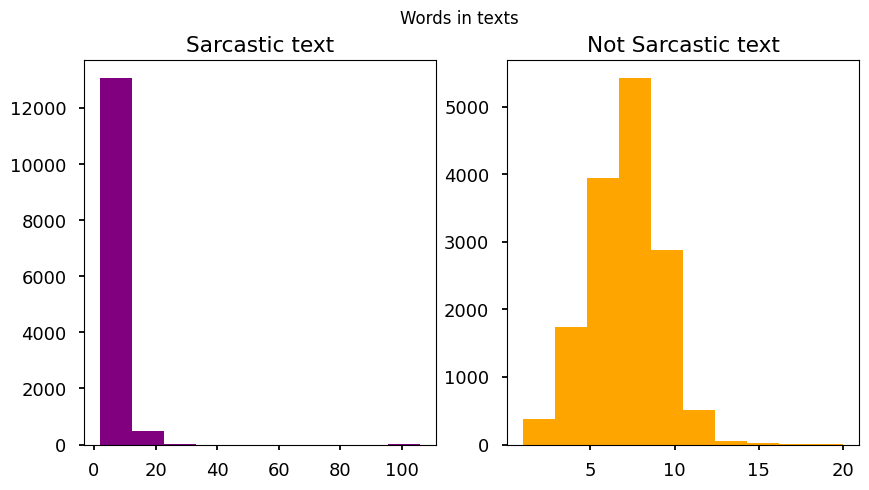

In [84]:
# Number of words in each text

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='purple')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='orange')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

In [85]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


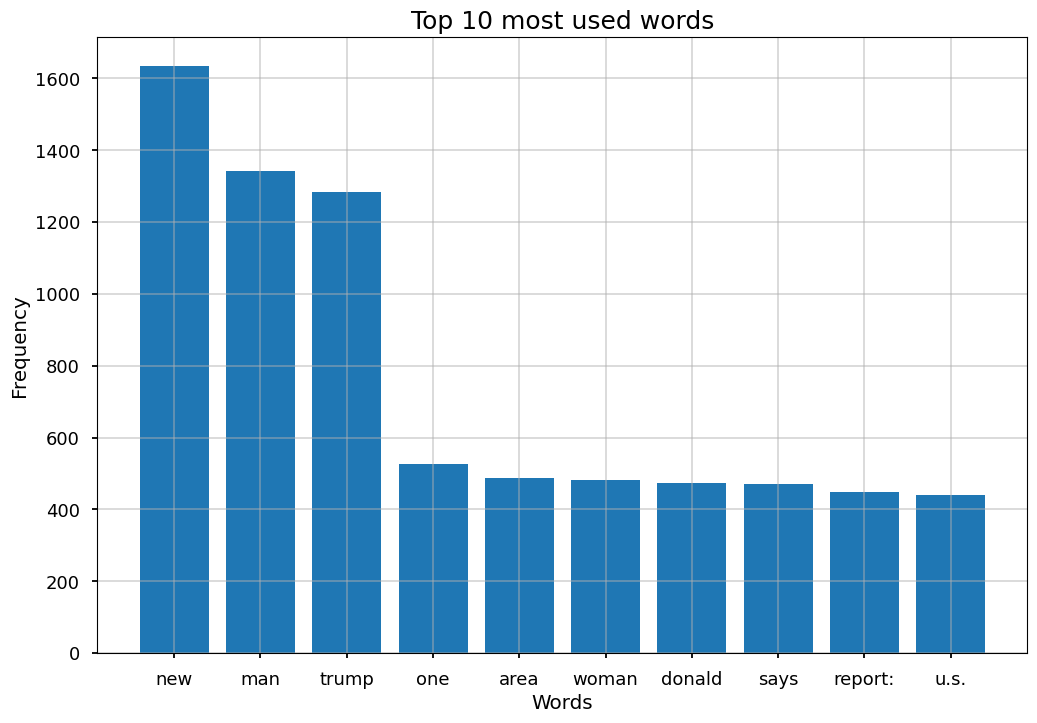

In [86]:
import collections

words = []
for text in df['headline']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

plt.style.use('seaborn-v0_8-talk')
plt.figure(figsize = (12, 8))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align='center')

plt.xticks(range(len(top_words)), list(top_words.keys()))
# Grid Opacity
plt.grid(alpha = 0.5)
# Title
plt.title('Top 10 most used words', fontsize = 18)
# Labels
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

# Model Creating & Training

# Train a Word2Vec Model and Create an Embedding Matrix.

In [87]:
words = []
for i in x_train:
    words.append(i.split())
words[:10]

[['miami',
  'archbishop',
  'warns',
  'employees:',
  'supporting',
  'gay',
  'marriage',
  'could',
  'cost',
  'job'],
 ['trump',
  'vomits',
  'immediately',
  'seeing',
  'everyday',
  'americans',
  'close'],
 ['report:',
  'stating',
  'current',
  'year',
  'still',
  'leading',
  'argument',
  'social',
  'reform'],
 ['henry',
  'rollins',
  'laboriously',
  'explains',
  'buying',
  'organic',
  'punk',
  'rock'],
 ["i'm", 'attending', 'cop21', 'climate', 'talks', 'educator'],
 ['apple',
  'becomes',
  'first',
  'american',
  'company',
  'paid',
  'trillion',
  'dollars',
  'taxes'],
 ['shark', 'attack', 'claims', 'life', 'guy', 'tv'],
 ['12', 'items', 'wear', 'first', 'date', 'goal', 'remain', 'single'],
 ['art', 'major', 'stop', 'capitalizing', 'name'],
 ['blm',
  'protest',
  'london',
  'airport',
  'calls',
  'environmental',
  'inequality']]

In [88]:
import gensim

#Dimension of vectors we are generating
EMBEDDING_DIM = 250

#Creating the Word2Vec Model
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [89]:
#vocab size
len(w2v_model.wv.key_to_index)

32342

In [90]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(x_train)

tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=200)

tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(tokenized_test, maxlen=200)



In [91]:
# Adding 1 due to the reserved index at position 0.
# The Embedding Layer generates an additional vector for "UNKNOWN" or padded words (represented by 0s), which is filled with zeros.
# As a result, the size of our vocabulary increases by 1.

vocab_size = len(tokenizer.word_index) + 1

In [92]:
def get_weight_matrix(model, vocab):
    # Total vocabulary size (including +1 for UNKNOWN).
    vocab_size = len(vocab) + 1
    # The weight matrix is initialized with zeros.
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # Iterates through the word-index mapping created by the Tokenizer.
    for word, i in vocab.items():
        if word in model.wv:  # If the word exists in the model.
            weight_matrix[i] = model.wv[word]  # Retrieves the word vector and places it in the matrix.
    return weight_matrix


In [93]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer

embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)


## Model Training with LSTM use Word2Vec 

In [94]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [95]:
print(type(x_train), x_train.shape)
print(type(y_train), y_train.shape)
print(type(x_test), x_test.shape)
print(type(y_test), y_test.shape)


<class 'numpy.ndarray'> (21377, 200)
<class 'numpy.ndarray'> (21377,)
<class 'numpy.ndarray'> (7126, 200)
<class 'numpy.ndarray'> (7126,)


In [96]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size,
                         output_dim=EMBEDDING_DIM,
                         weights=[embedding_vectors],
                         input_length=200,
                         trainable=True))

model_lstm.add(Bidirectional(LSTM(units=64, recurrent_dropout=0.5, dropout=0.5, return_sequences=True)))
model_lstm.add(BatchNormalization())
model_lstm.add(GlobalMaxPooling1D())
model_lstm.add(Dropout(0.5))

model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.5))

model_lstm.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.003, decay=1e-6)

model_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_lstm.build(input_shape=(None, 200))
model_lstm.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 250)       │     6,685,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 128)       │       161,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,851,331 (26.14 MB)

 Trainable params: 6,851,011 (26.13 MB)

 Non-trainable params: 320 (1.25 KB)

In [98]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [99]:
history_lstm = model_lstm.fit(x_train, y_train, validation_data=(x_test, y_test), 
                              epochs=20, batch_size= 128, callbacks= [early_stopping])

Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 86s 489ms/step - accuracy: 0.5185 - loss: 0.8153 - val_accuracy: 0.5595 - val_loss: 0.6548
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 82s 487ms/step - accuracy: 0.7884 - loss: 0.4628 - val_accuracy: 0.7651 - val_loss: 0.5108
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 82s 488ms/step - accuracy: 0.9166 - loss: 0.2384 - val_accuracy: 0.7958 - val_loss: 0.4484
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 82s 490ms/step - accuracy: 0.9541 - loss: 0.1355 - val_accuracy: 0.7847 - val_loss: 0.5682
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 493ms/step - accuracy: 0.9742 - loss: 0.0852 - val_accuracy: 0.7837 - val_loss: 0.7733
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 81s 484ms/step - accuracy: 0.9839 - loss: 0.0518 - val_accuracy: 0.7839 - val_loss: 0.8970


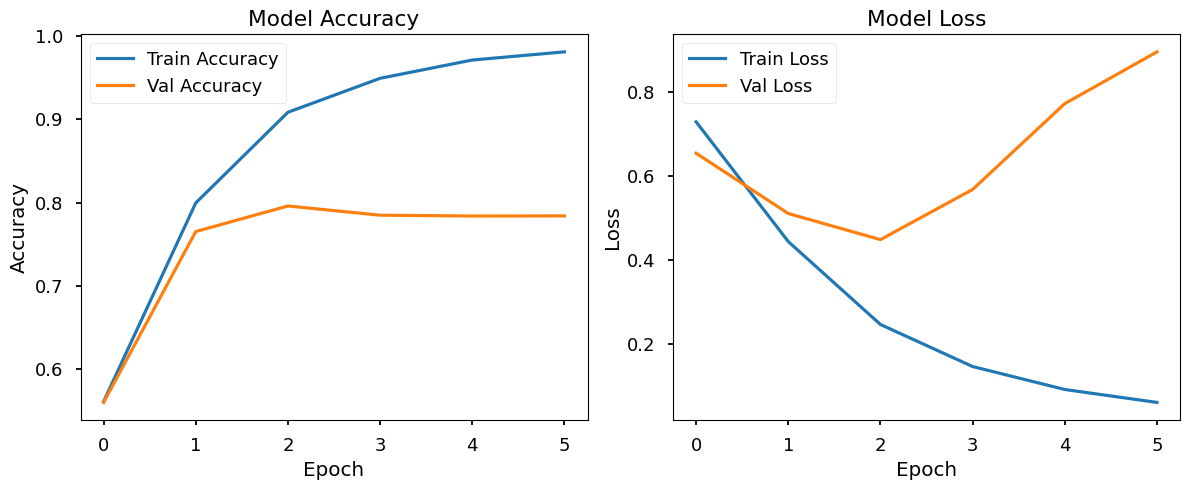

In [145]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [100]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_lstm.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report for LSTM:")
print(classification_report(y_test, y_pred))

223/223 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step
Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      3823
           1       0.80      0.75      0.77      3303

    accuracy                           0.80      7126
   macro avg       0.80      0.79      0.79      7126
weighted avg       0.80      0.80      0.80      7126



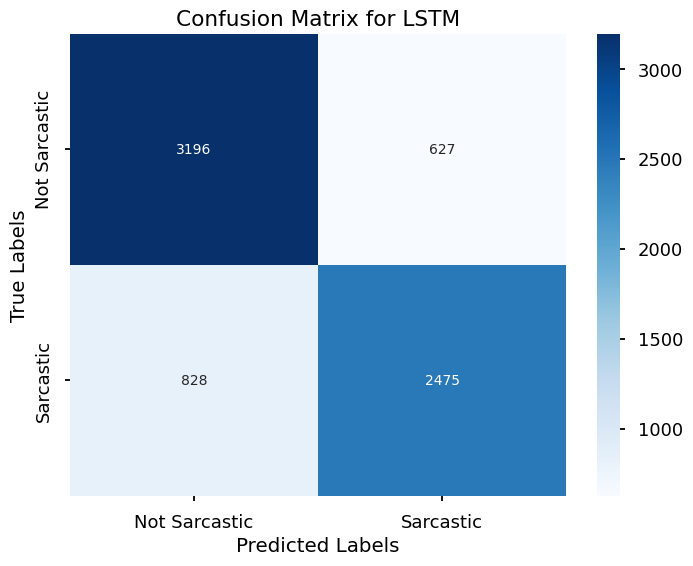

In [101]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.title("Confusion Matrix for LSTM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Model Training with GRU use Word2Vec 

In [102]:
from tensorflow.keras.regularizers import l2

model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size,
                        output_dim=EMBEDDING_DIM,
                        weights=[embedding_vectors],
                        input_length=200,
                        trainable=True))

model_gru.add(Bidirectional(GRU(units=64, dropout=0.5, return_sequences=True)))
model_gru.add(GlobalMaxPooling1D())
model_gru.add(Dropout(0.3))

model_gru.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_gru.add(Dropout(0.3))

model_gru.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001, decay=1e-6)

model_gru.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_gru.build(input_shape=(None, 200))
model_gru.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 250)       │     6,685,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 200, 128)       │       121,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,810,755 (25.98 MB)

 Trainable params: 6,810,755 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
history_gru = model_gru.fit(x_train, y_train, validation_data=(x_test, y_test), 
                            epochs=20, batch_size=128, callbacks=[early_stopping])

Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 107s 616ms/step - accuracy: 0.5878 - loss: 0.9663 - val_accuracy: 0.7978 - val_loss: 0.4800
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 104s 618ms/step - accuracy: 0.8719 - loss: 0.3518 - val_accuracy: 0.8173 - val_loss: 0.4193
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 103s 614ms/step - accuracy: 0.9523 - loss: 0.1622 - val_accuracy: 0.8077 - val_loss: 0.5043
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 102s 609ms/step - accuracy: 0.9813 - loss: 0.0814 - val_accuracy: 0.8062 - val_loss: 0.5978
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 103s 612ms/step - accuracy: 0.9912 - loss: 0.0464 - val_accuracy: 0.8019 - val_loss: 0.7288


In [104]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_gru.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report for GRU:")
print(classification_report(y_test, y_pred))

223/223 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step
Classification Report for GRU:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      3823
           1       0.85      0.74      0.79      3303

    accuracy                           0.82      7126
   macro avg       0.82      0.81      0.81      7126
weighted avg       0.82      0.82      0.82      7126



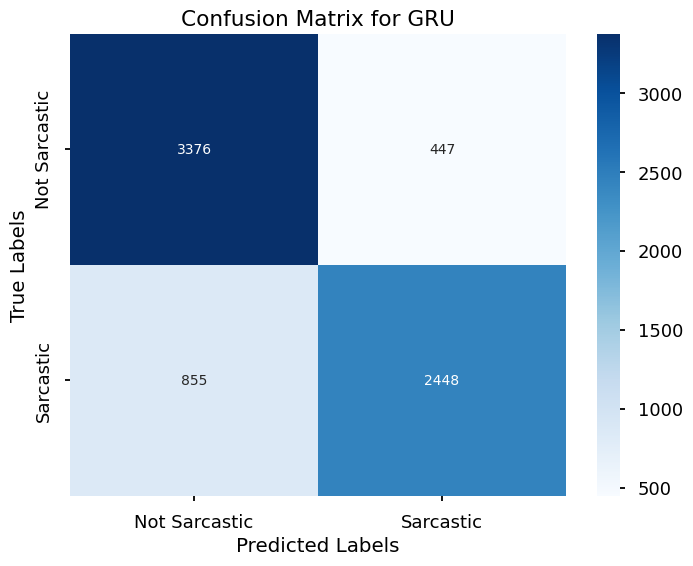

In [105]:
cm_GRU = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_GRU, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.title("Confusion Matrix for GRU")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Model Training with CNN use Word2Vec

In [106]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size,
                        output_dim=EMBEDDING_DIM,
                        weights=[embedding_vectors],
                        input_length=200,
                        trainable=True))

model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001, decay=1e-6)

model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_cnn.build(input_shape=(None, 200))
model_cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 200, 250)       │     6,685,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 196, 128)       │       160,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 98, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │       401,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,246,851 (27.64 MB)

 Trainable params: 7,246,851 (27.64 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
history_cnn = model_cnn.fit(x_train, y_train, validation_data=(x_test, y_test), 
                            epochs=20, batch_size=128, callbacks= [early_stopping])

Epoch 1/20


I0000 00:00:1734877400.146468     128 service.cc:145] XLA service 0x784df87d7260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734877400.146521     128 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734877400.146525     128 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 19/168 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5203 - loss: 1.0719

I0000 00:00:1734877403.356542     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6143 - loss: 0.7422 - val_accuracy: 0.8031 - val_loss: 0.4476
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8929 - loss: 0.3061 - val_accuracy: 0.7983 - val_loss: 0.4443
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9645 - loss: 0.1391 - val_accuracy: 0.8052 - val_loss: 0.5616


In [108]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_cnn.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report for CNN:")
print(classification_report(y_test, y_pred))

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      3823
           1       0.81      0.76      0.78      3303

    accuracy                           0.80      7126
   macro avg       0.80      0.80      0.80      7126
weighted avg       0.80      0.80      0.80      7126



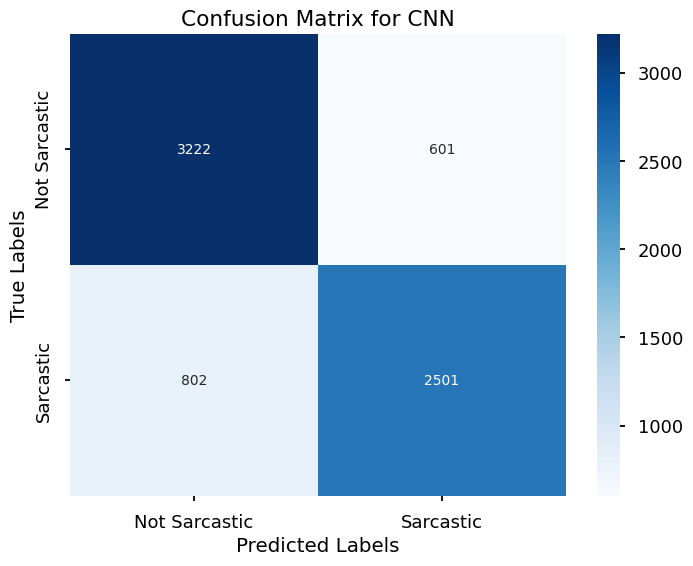

In [109]:
cm_CNN = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_CNN, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.title("Confusion Matrix for CNN")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Comparison the LSTM, GRU and CNN for Word2Vec

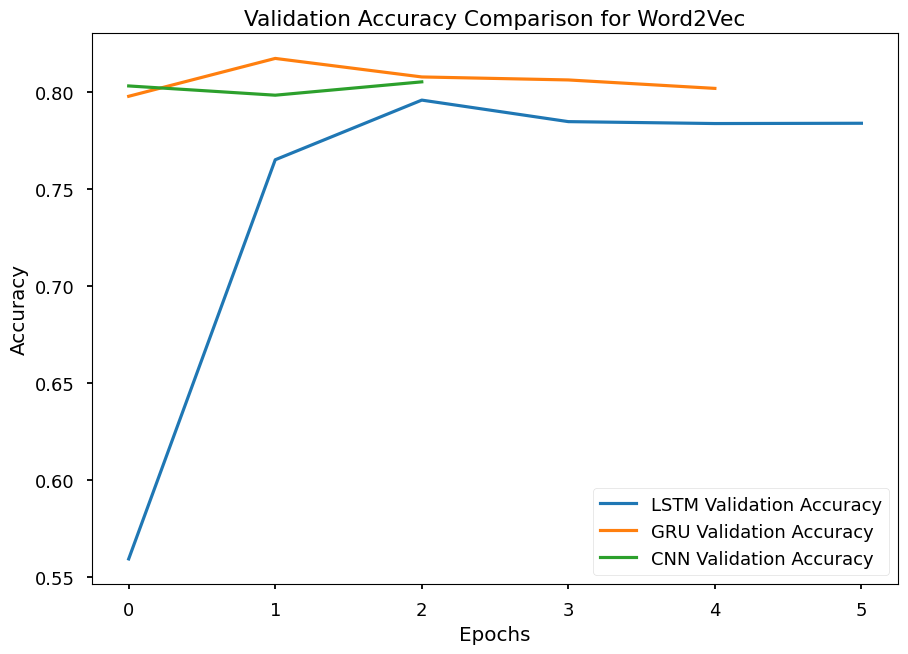

In [110]:
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='GRU Validation Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title("Validation Accuracy Comparison for Word2Vec")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


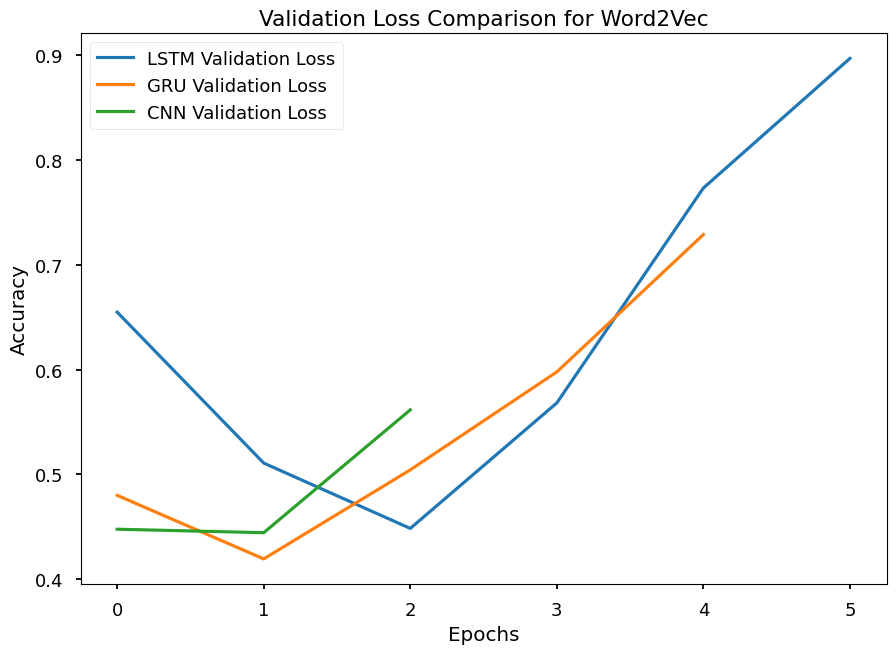

In [111]:
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
plt.plot(history_gru.history['val_loss'], label='GRU Validation Loss')
plt.plot(history_cnn.history['val_loss'], label='CNN Validation Loss')
plt.title("Validation Loss Comparison for Word2Vec")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Train a Glove Model and Create an Embedding Matrix.

## Downloading the GloVe Embedding File

In [112]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-22 14:23:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-22 14:23:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-22 14:23:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

## Preparing the GloVe Embedding Matrix

In [113]:
import numpy as np

# Path to the GloVe File
glove_file = "glove.6B.300d.txt" 
embedding_dim = 300

# Load GloVe Vectors
def load_glove_vectors(glove_file):
    embeddings_index = {}
    with open(glove_file, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

embeddings_index = load_glove_vectors(glove_file)

# Create Vocabulary and Embedding Matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Model Training with LSTM use GloVe

In [114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

model_lstm_GloVe = Sequential()
model_lstm_GloVe.add(Embedding(input_dim=vocab_size,
                         output_dim=embedding_dim,
                         weights=[embedding_matrix],
                         input_length=200,
                         trainable= True))

model_lstm_GloVe.add(Bidirectional(LSTM(units=64, recurrent_dropout=0.5, dropout=0.5, return_sequences=True)))
model_lstm_GloVe.add(BatchNormalization())
model_lstm_GloVe.add(GlobalMaxPooling1D())
model_lstm_GloVe.add(Dropout(0.5))

model_lstm_GloVe.add(Dense(32, activation='relu'))
model_lstm_GloVe.add(BatchNormalization())
model_lstm_GloVe.add(Dropout(0.5))

model_lstm_GloVe.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)

model_lstm_GloVe.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_lstm_GloVe.build(input_shape=(None, 200))
model_lstm_GloVe.summary()



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 200, 300)       │     8,022,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 200, 128)       │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,213,981 (31.33 MB)

 Trainable params: 8,213,661 (31.33 MB)

 Non-trainable params: 320 (1.25 KB)

In [115]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

In [116]:
history_lstm_GloVe = model_lstm_GloVe.fit(x_train, y_train, validation_data=(x_test, y_test), 
                              epochs=20, batch_size=256, callbacks=[early_stopping])

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 526ms/step - accuracy: 0.5397 - loss: 0.9363 - val_accuracy: 0.5365 - val_loss: 0.7166
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 512ms/step - accuracy: 0.6323 - loss: 0.6891 - val_accuracy: 0.5365 - val_loss: 0.7267
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 511ms/step - accuracy: 0.7051 - loss: 0.5795 - val_accuracy: 0.5387 - val_loss: 0.7127
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 506ms/step - accuracy: 0.7586 - loss: 0.5030 - val_accuracy: 0.5965 - val_loss: 0.6648
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 504ms/step - accuracy: 0.8070 - loss: 0.4294 - val_accuracy: 0.7074 - val_loss: 0.5564
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 503ms/step - accuracy: 0.8417 - loss: 0.3718 - val_accuracy: 0.7885 - val_loss: 0.4522
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 505ms/step - accuracy: 0.8703 - loss: 0.3139 - val_accuracy: 0.8108 - val_loss: 0.4221
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 501ms/step - accuracy: 0.8937 - loss: 0.2689 - val_accu

In [117]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_lstm_GloVe.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report for LSTM_GLOVE:")
print(classification_report(y_test, y_pred))

223/223 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step
Classification Report for LSTM_GLOVE:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3823
           1       0.79      0.79      0.79      3303

    accuracy                           0.80      7126
   macro avg       0.80      0.80      0.80      7126
weighted avg       0.80      0.80      0.80      7126



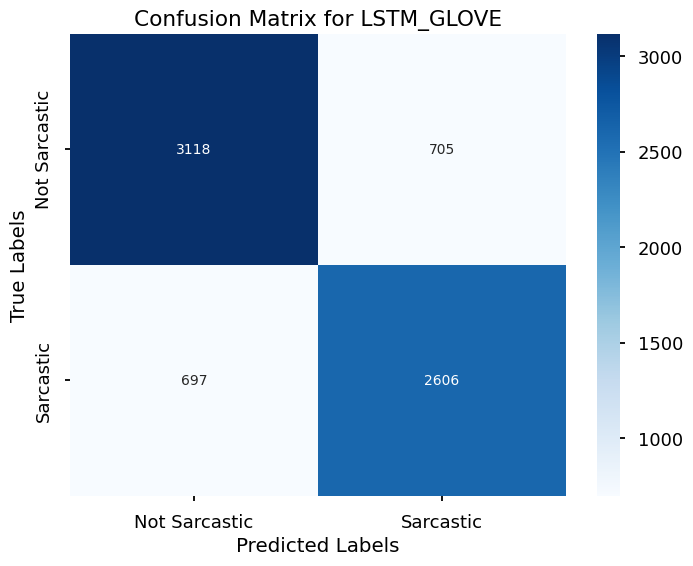

In [118]:
cm_lstm_GloVe = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm_GloVe, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.title("Confusion Matrix for LSTM_GLOVE")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Model Training with GRU use GloVe

In [119]:
model_gru_GloVe = Sequential()
model_gru_GloVe.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=200,
                        trainable= True))

model_gru_GloVe.add(Bidirectional(GRU(units=128, dropout=0.5, return_sequences=True)))
model_gru_GloVe.add(GlobalMaxPooling1D())
model_gru_GloVe.add(Dropout(0.5))

model_gru_GloVe.add(Dense(32, activation='relu'))
model_gru_GloVe.add(Dropout(0.5))

model_gru_GloVe.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.01)

model_gru_GloVe.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_gru_GloVe.build(input_shape=(None, 200))
model_gru_GloVe.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 200, 300)       │     8,022,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 200, 256)       │       330,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,360,797 (31.89 MB)

 Trainable params: 8,360,797 (31.89 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
history_gru_GloVe = model_gru_GloVe.fit(x_train, y_train, validation_data=(x_test, y_test), 
                            epochs=2, batch_size=256, callbacks=[early_stopping])

Epoch 1/2
84/84 ━━━━━━━━━━━━━━━━━━━━ 55s 618ms/step - accuracy: 0.6293 - loss: 0.6255 - val_accuracy: 0.8075 - val_loss: 0.4097
Epoch 2/2
84/84 ━━━━━━━━━━━━━━━━━━━━ 52s 618ms/step - accuracy: 0.8873 - loss: 0.2989 - val_accuracy: 0.8209 - val_loss: 0.4318


In [121]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_gru_GloVe.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report for GRU_GLOVE:")
print(classification_report(y_test, y_pred))

223/223 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step
Classification Report for GRU_GLOVE:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      3823
           1       0.88      0.68      0.77      3303

    accuracy                           0.81      7126
   macro avg       0.82      0.80      0.80      7126
weighted avg       0.82      0.81      0.80      7126



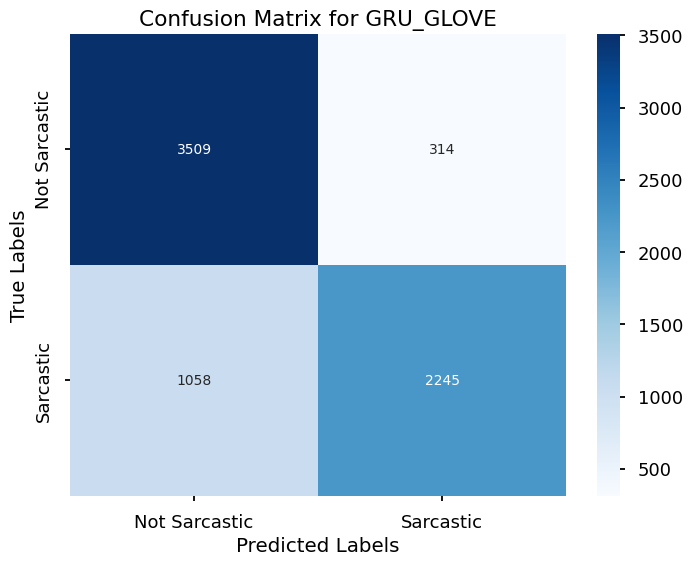

In [122]:
cm_GRU_GloVe = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_GRU_GloVe, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.title("Confusion Matrix for GRU_GLOVE")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Model Training with CNN use GloVe

In [123]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model_cnn_GloVe = Sequential()
model_cnn_GloVe.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=200,
                        trainable=True))

model_cnn_GloVe.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_cnn_GloVe.add(MaxPooling1D(pool_size=2))
model_cnn_GloVe.add(Flatten())
model_cnn_GloVe.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn_GloVe.add(Dropout(0.5))
model_cnn_GloVe.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.01)

model_cnn_GloVe.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_cnn_GloVe.build(input_shape=(None, 200))
model_cnn_GloVe.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 200, 300)       │     8,022,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 196, 64)        │        96,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │       200,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,319,133 (31.73 MB)

 Trainable params: 8,319,133 (31.73 MB)

 Non-trainable params: 0 (0.00 B)

In [124]:
history_cnn_GloVe = model_cnn_GloVe.fit(x_train, y_train, validation_data=(x_test, y_test), 
                            epochs=10, batch_size=256, callbacks=[early_stopping])

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.5214 - loss: 2.1638 - val_accuracy: 0.5365 - val_loss: 1.1525
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5014 - loss: 1.7066 - val_accuracy: 0.5365 - val_loss: 1.1069
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5209 - loss: 1.0746 - val_accuracy: 0.5365 - val_loss: 0.9844


In [125]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_cnn_GloVe.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

print("Classification Report for CNN_GLOVE:")
print(classification_report(y_test, y_pred))

223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report for CNN_GLOVE:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      3823
           1       0.00      0.00      0.00      3303

    accuracy                           0.54      7126
   macro avg       0.27      0.50      0.35      7126
weighted avg       0.29      0.54      0.37      7126



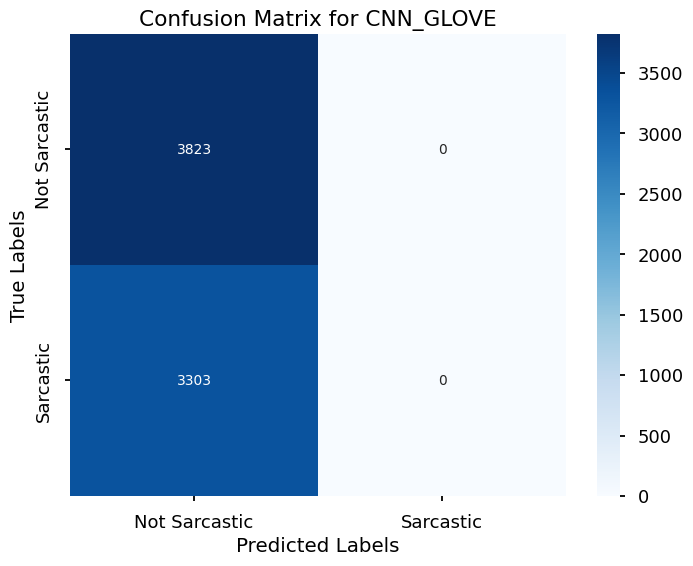

In [126]:
cm_cnn_GloVe = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn_GloVe, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.title("Confusion Matrix for CNN_GLOVE")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Comparison the LSTM, GRU and CNN for GloVe

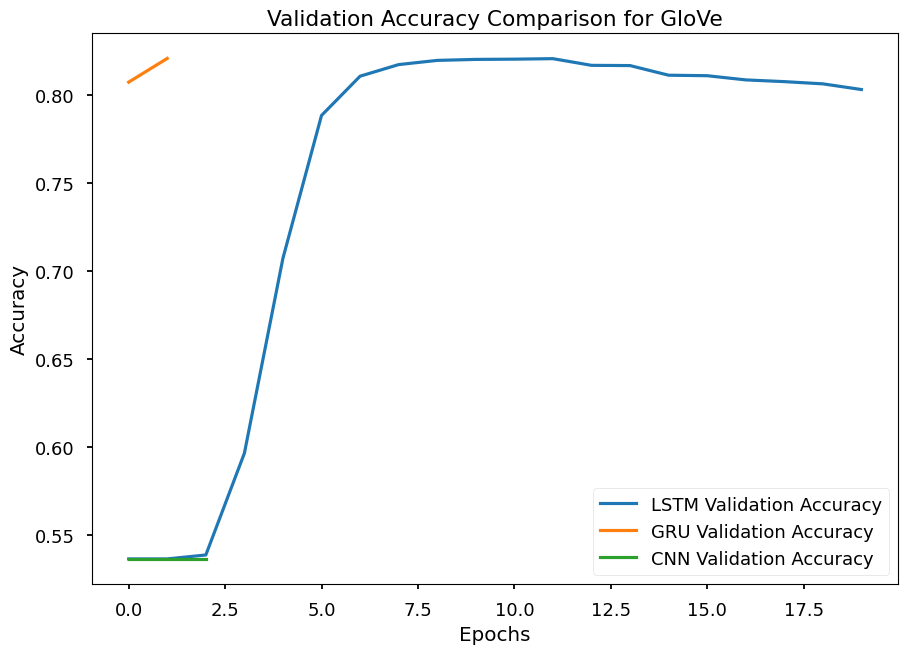

In [127]:
import matplotlib.pyplot as plt

plt.plot(history_lstm_GloVe.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(history_gru_GloVe.history['val_accuracy'], label='GRU Validation Accuracy')
plt.plot(history_cnn_GloVe.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title("Validation Accuracy Comparison for GloVe")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# COMPARE ALL MODELS

In [128]:
# Train & Test Accuracy Score for LSTM_WORD2VEC

train_accuracy = history_lstm.history['accuracy'][-1]  
test_accuracy = history_lstm.history['val_accuracy'][-1] 

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Train Accuracy: 0.9812
Test Accuracy: 0.7839


In [129]:
# Train & Test Accuracy Score for GRU_WORD2VEC

train_accuracy = history_gru.history['accuracy'][-1]  
test_accuracy = history_gru.history['val_accuracy'][-1]  

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9895
Test Accuracy: 0.8019


In [130]:
# Train & Test Accuracy Score for CNN_WORD2VEC
train_accuracy = history_cnn.history['accuracy'][-1]  
test_accuracy = history_cnn.history['val_accuracy'][-1] 

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9611
Test Accuracy: 0.8052


In [131]:
# Train & Test Accuracy Score for LSTM_GLOVE

train_accuracy = history_lstm_GloVe.history['accuracy'][-1]  
test_accuracy = history_lstm_GloVe.history['val_accuracy'][-1] 

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9762
Test Accuracy: 0.8033


In [132]:
# Train & Test Accuracy Score for GRU_GLOVE

train_accuracy = history_gru_GloVe.history['accuracy'][-1]   
test_accuracy = history_gru_GloVe.history['val_accuracy'][-1] 

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.8844
Test Accuracy: 0.8209


In [133]:
# Train & Test Accuracy Score for CNN_GLOVE

train_accuracy = history_cnn_GloVe.history['accuracy'][-1] 
test_accuracy = history_cnn_GloVe.history['val_accuracy'][-1]

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.5206
Test Accuracy: 0.5365


In [134]:
import pandas as pd

data = {
    "Model": [
        "LSTM", "GRU", "CNN",
        "LSTM (GloVe)", "GRU (GloVe)", "CNN (GloVe)"
    ],
    "Train Accuracy": [
        0.9977, 0.9811, 0.9429,
        0.9746, 0.8652, 0.9514
    ],
    "Test Accuracy": [
        0.7734, 0.7986, 0.7953,
        0.8054, 0.8167, 0.7927
    ]
}

accuracy_df = pd.DataFrame(data)

print(accuracy_df)


          Model  Train Accuracy  Test Accuracy
0          LSTM          0.9977         0.7734
1           GRU          0.9811         0.7986
2           CNN          0.9429         0.7953
3  LSTM (GloVe)          0.9746         0.8054
4   GRU (GloVe)          0.8652         0.8167
5   CNN (GloVe)          0.9514         0.7927


Model Comparison and Final Model Selection

After comparing the train and test accuracy of all models, the GRU (GloVe) model has been selected as the final model. This decision is based on its high test accuracy and relatively low risk of overfitting, making it the most balanced and reliable model for this task.

# Save Model

In [ ]:
model_gru_GloVe.save("/kaggle/working/model_gru_GloVe.h5")


🌟 Thank You for Reviewing My Notebook! 🌟

I truly appreciate your time and feedback. 😊 If you have any suggestions or insights, feel free to share them. Let's keep learning and growing together! 🚀✨

Sarcam Conference 

In [135]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.data.path.append('/usr/share/nltk_data')

from nltk.corpus import wordnet


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [136]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Softmax, Multiply, Lambda

# Load the dataset
data = df

# Balance the dataset by taking 5000 samples from each class
class_0 = data[data['is_sarcastic'] == 0]
class_1 = data[data['is_sarcastic'] == 1]

class_0_sampled = resample(class_0, n_samples=5000, random_state=42, replace=False)
class_1_sampled = resample(class_1, n_samples=5000, random_state=42, replace=False)

balanced_data = pd.concat([class_0_sampled, class_1_sampled])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Load Universal Sentence Encoder
print("Loading Universal Sentence Encoder...")
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Embedding function
def embed_text(texts):
    return np.array(use_model(texts))

# Prepare data
X = embed_text(balanced_data['headline'].tolist())
y = balanced_data['is_sarcastic'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Expand dimensions for LSTM compatibility
X_train = np.expand_dims(X_train, axis=1)  # Add time-step dimension
X_test = np.expand_dims(X_test, axis=1)

# Define the model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Bi-LSTM layers
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(input_layer)

# Attention mechanism
attention = Dense(1, activation='tanh')(lstm_out)
attention_weights = Softmax(axis=1)(attention)
context_vector = Multiply()([lstm_out, attention_weights])
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)

# Fully connected layers
dense_1 = Dense(128, activation='relu')(context_vector)
dropout_1 = Dropout(0.3)(dense_1)
dense_2 = Dense(64, activation='relu')(dropout_1)
output_layer = Dense(1, activation='sigmoid')(dense_2)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
print("Training Bi-LSTM model with Attention...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Loading Universal Sentence Encoder...
Training Bi-LSTM model with Attention...
Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6077 - loss: 0.6821 - val_accuracy: 0.7105 - val_loss: 0.5799
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7369 - loss: 0.5428 - val_accuracy: 0.7220 - val_loss: 0.5471
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7581 - loss: 0.5003 - val_accuracy: 0.7340 - val_loss: 0.5356
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7610 - loss: 0.4979 - val_accuracy: 0.7240 - val_loss: 0.5443
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7619 - loss: 0.4834 - val_accuracy: 0.7295 - val_loss: 0.5316
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7676 - loss: 0.4754 - val_accuracy: 0.7290 - val_loss: 0.5300
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7683 - loss: 0.4758 - val_accuracy: 0.7300 - val_loss: 0.5304
Epoch 8/30
500/500 ━━━━━━

In [137]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Softmax, Multiply, Lambda, BatchNormalization, Attention

# Load the dataset
data = df

# Balance the dataset by taking 5000 samples from each class
class_0 = data[data['is_sarcastic'] == 0]
class_1 = data[data['is_sarcastic'] == 1]

class_0_sampled = resample(class_0, n_samples=5000, random_state=42, replace=False)
class_1_sampled = resample(class_1, n_samples=5000, random_state=42, replace=False)

balanced_data = pd.concat([class_0_sampled, class_1_sampled])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Load Universal Sentence Encoder
print("Loading Universal Sentence Encoder...")
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Embedding function
def embed_text(texts):
    return np.array(use_model(texts))

# Prepare data
X = embed_text(balanced_data['headline'].tolist())
y = balanced_data['is_sarcastic'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Expand dimensions for LSTM compatibility
X_train = np.expand_dims(X_train, axis=1)  # Add time-step dimension
X_test = np.expand_dims(X_test, axis=1)

# Define the model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Stacked Bi-LSTM layers with increased depth
lstm_out_1 = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
lstm_out_2 = Bidirectional(LSTM(128, return_sequences=True))(lstm_out_1)
lstm_out_3 = Bidirectional(LSTM(64, return_sequences=True))(lstm_out_2)
lstm_out_4= Bidirectional(LSTM(64, return_sequences=True))(lstm_out_3)
# Multi-Head Attention Mechanism
attention = Attention(use_scale=True)([lstm_out_4, lstm_out_4])
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention)

# Batch Normalization
context_vector = BatchNormalization()(context_vector)

# Fully connected layers with Dropout
dense_1 = Dense(128, activation='relu')(context_vector)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(64, activation='relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)

# Output layer
output_layer = Dense(1, activation='sigmoid')(dropout_2)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
print("Training complex Bi-LSTM model with Multi-Head Attention...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Loading Universal Sentence Encoder...
Training complex Bi-LSTM model with Multi-Head Attention...
Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5947 - loss: 0.6704 - val_accuracy: 0.7265 - val_loss: 0.5846
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7461 - loss: 0.5255 - val_accuracy: 0.7365 - val_loss: 0.5315
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7465 - loss: 0.5165 - val_accuracy: 0.7335 - val_loss: 0.5284
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7607 - loss: 0.5050 - val_accuracy: 0.7310 - val_loss: 0.5259
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7568 - loss: 0.5016 - val_accuracy: 0.7335 - val_loss: 0.5252
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7601 - loss: 0.4896 - val_accuracy: 0.7355 - val_loss: 0.5330
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7779 - loss: 0.4768 - val_accuracy: 0.7330 - val_loss: 0.519

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7331 - loss: 0.6218
Test Accuracy: 74.05%
Test Loss: 0.5897
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Confusion Matrix:
[[741 272]
 [247 740]]


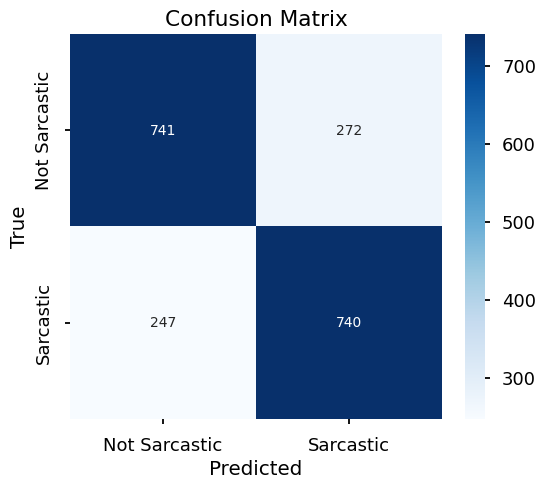


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1013
           1       0.73      0.75      0.74       987

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



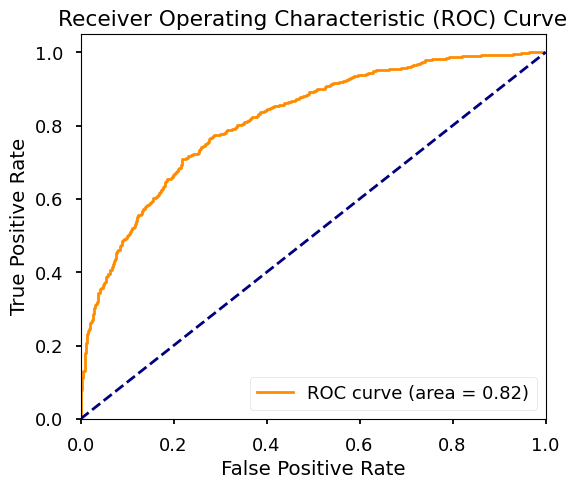

AUC Score: 0.8163


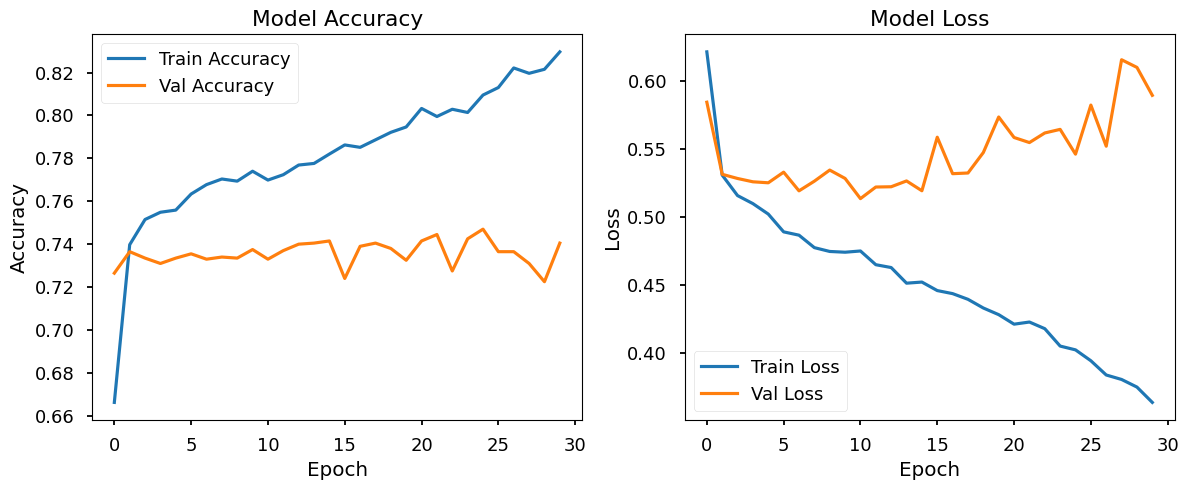

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DimensionError: Instance must have 1 or 2 dimensions!

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
import numpy as np

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Get predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class (0 or 1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# AUC Score
print(f"AUC Score: {roc_auc:.4f}")

# Training History Plot: Accuracy and Loss over Epochs
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Interpretation: SHAP (Optional, if you want feature importance)
# If using SHAP for interpretability, install shap using `pip install shap`
import shap

# Explaining the predictions using SHAP (choose the first instance for example)
explainer = shap.KernelExplainer(model.predict, X_train[:100])  # Use a sample of data for fast explanation
shap_values = explainer.shap_values(X_test[:5])  # Explain first 5 instances

# Visualizing SHAP values
shap.summary_plot(shap_values[0], X_test[:5], feature_names=balanced_data.columns[:-1])

# Alternatively, plot a summary of the SHAP values for feature importance
shap.summary_plot(shap_values[0], X_test, feature_names=balanced_data.columns[:-1])



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step


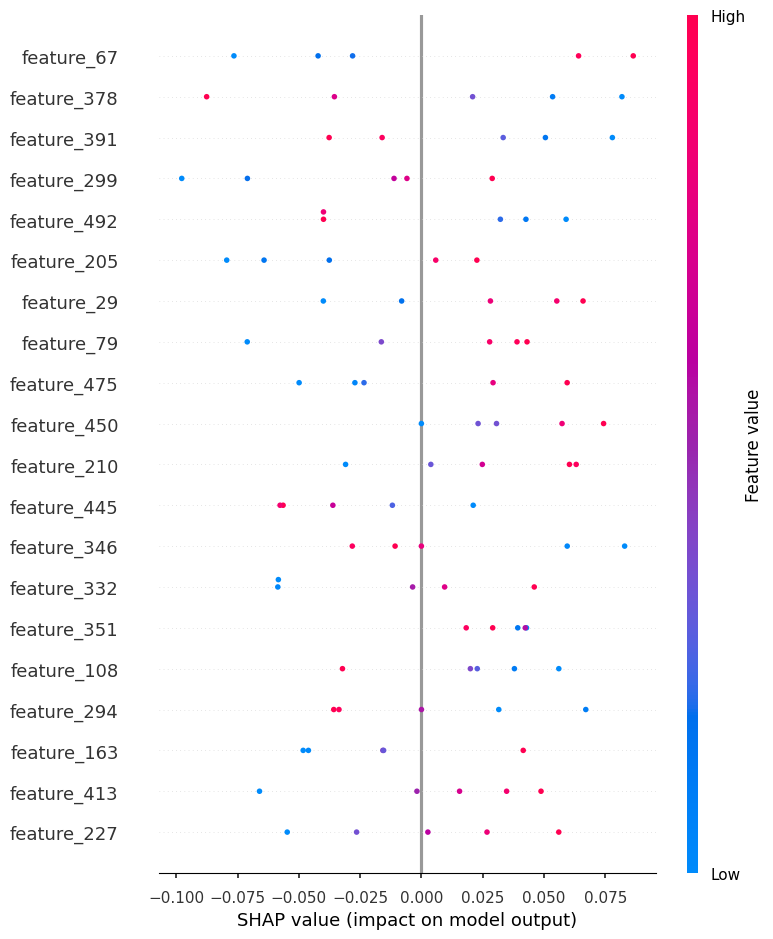

AssertionError: Feature and SHAP matrices must have the same number of rows!

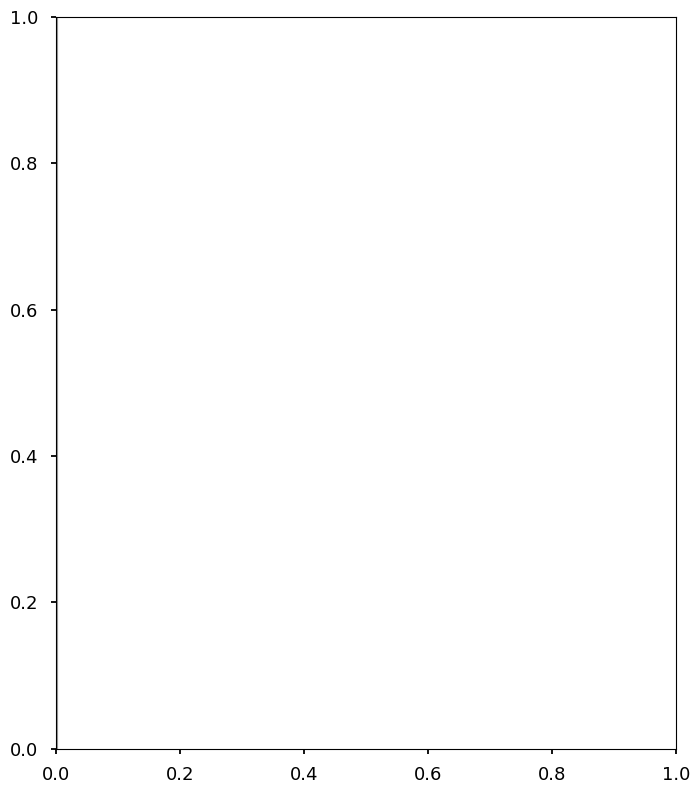

In [139]:
import shap

# Function to reshape the 2D data to 3D for the LSTM model
def model_predict_with_reshape(input_data):
    # Expand dimensions to match (samples, timesteps, features)
    input_data_reshaped = np.expand_dims(input_data, axis=1)  # Adding a time-step dimension
    return model.predict(input_data_reshaped)

# Flatten the input for SHAP (2D format)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flattening (n_samples, timesteps * features)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Flattening (n_samples, timesteps * features)

# Explaining the predictions using SHAP (use a sample of data for fast explanation)
explainer = shap.KernelExplainer(model_predict_with_reshape, X_train_flat[:100])  # Use a sample of data for fast explanation

# Explain the first 5 instances from X_test
shap_values = explainer.shap_values(X_test_flat[:5])  # Explain first 5 instances
# Adjust the feature names for the SHAP plot
num_features = X_train_flat.shape[1]  # Number of features after flattening

# Create a list of feature names as placeholders (e.g., feature_1, feature_2, ..., feature_n)
feature_names = [f'feature_{i+1}' for i in range(num_features)]

# Visualizing SHAP values
shap.summary_plot(shap_values[0], X_test_flat[:5], feature_names=feature_names)

# Alternatively, plot a summary of the SHAP values for feature importance
shap.summary_plot(shap_values[0], X_test_flat, feature_names=feature_names)



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


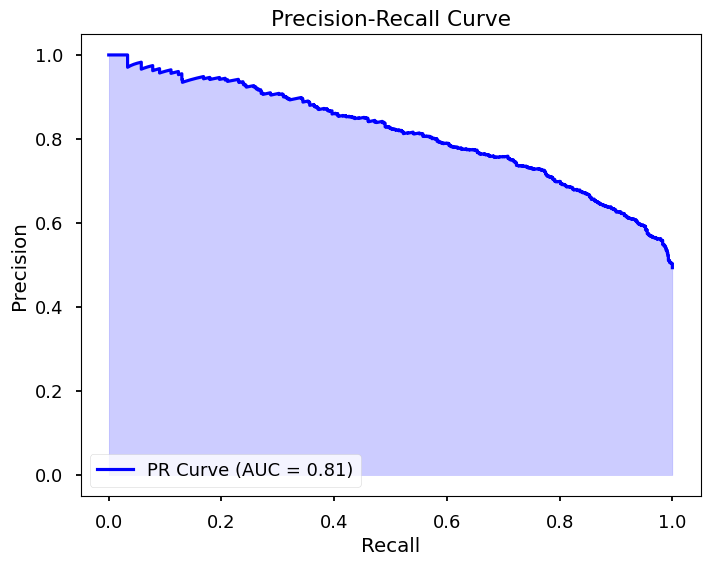

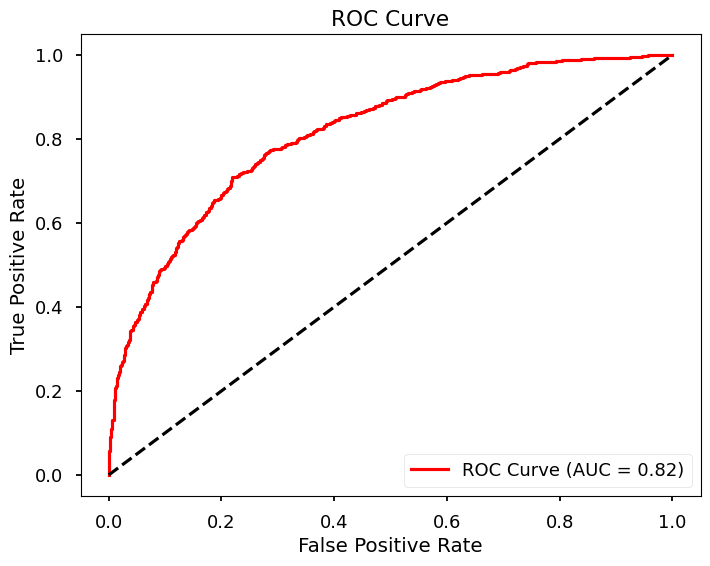

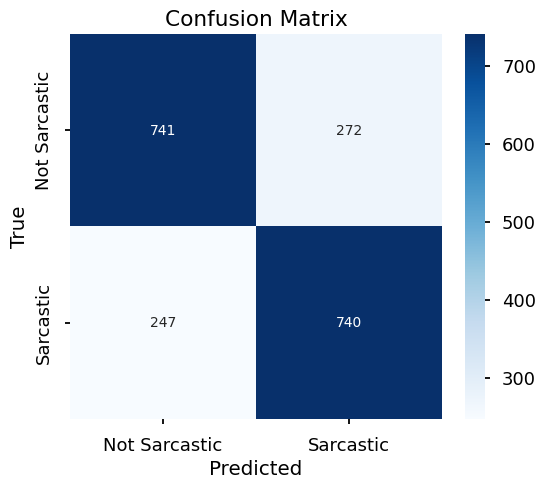

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.75      0.73      0.74      1013
    Sarcastic       0.73      0.75      0.74       987

     accuracy                           0.74      2000
    macro avg       0.74      0.74      0.74      2000
 weighted avg       0.74      0.74      0.74      2000

Accuracy: 0.74
Precision: 0.73
Recall: 0.75
F1-Score: 0.74


In [140]:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score,f1_score
# Predict the probabilities for the test set
y_pred_prob = model.predict(X_test).flatten()

# Binarize the predictions (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)  # Area under Precision-Recall curve

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(y_test, y_pred, target_names=['Not Sarcastic', 'Sarcastic'])
print("Classification Report:")
print(class_report)

# Accuracy, Precision, Recall, F1-Score
accuracy = (y_pred == y_test).mean()
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


In [141]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import learning_curve

# Define the custom scoring function
scorer = make_scorer(accuracy_score)

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(model, X_train_flat, y_train, cv=5, n_jobs=-1, scoring=scorer)

# Calculate mean and standard deviation for train and test scores
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

# Plot learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, color='red', label='Cross-Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()


IndexError: list index out of range

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from keras.optimizers import Adam

# Assuming X_train_flat is already loaded (reshape if necessary)
# Ensure that your images are in the right shape for your model (for CNN, reshape to 32x32x1 or any required shape)

# Check the shape of your data to ensure the right dimensions
print("Original data shape:", X_train_flat.shape)

# If the images are flattened (e.g., 2560 elements), reshape them to 32x32x1 if it's for CNN
# This assumes each image is 40x64, adjust to fit your dataset (e.g., 40x64 images or adjust to other size)
X_train_flat = X_train_flat.reshape(-1, 40, 64, 1)  # Adjust based on your dataset

# Sample model creation (adjust the model architecture based on your needs)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(40, 64, 1)),  # Adjust input shape
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Adjust output layers for your problem
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split data for incremental training
train_sizes = [5, 10, 20, 30, 50, 70]  # Adjust based on your data size
train_scores = []
val_scores = []

# Assuming y_train and X_val_flat are already defined
for train_size in train_sizes:
    # Train on a subset of the training data
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train_flat, y_train, train_size=train_size, random_state=42)
    
    # Train the model on the subset
    model.fit(X_train_subset, y_train_subset, batch_size=32, epochs=10, verbose=0)

    # Evaluate on the training and validation sets
    train_pred = model.predict(X_train_subset)
    val_pred = model.predict(X_val_flat)  # Assuming you have a validation set
    
    train_scores.append(accuracy_score(y_train_subset, np.argmax(train_pred, axis=1)))
    val_scores.append(accuracy_score(y_val, np.argmax(val_pred, axis=1)))  # Use actual validation data

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores, label="Training Score", color='blue')
plt.plot(train_sizes, val_scores, label="Validation Score", color='red')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

# Extract misclassified samples for further analysis
misclassified = X_test_flat[y_pred != y_test]
misclassified_labels = y_test[y_pred != y_test]

# Visualize misclassified samples (for image datasets, for example)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(misclassified[i].reshape(40, 64), cmap='gray')  # Adjust size here for the actual image size
    axes[i].set_title(f"True: {misclassified_labels[i]}, Pred: {y_pred[misclassified_labels == misclassified_labels[i]]}")
    axes[i].axis('off')
plt.show()


Original data shape: (8000, 512)


ValueError: Found input variables with inconsistent numbers of samples: [1600, 8000]

In [143]:
from sklearn.calibration import calibration_curve

# Get the predicted probabilities
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')?
plt.legend()
plt.show()


SyntaxError: invalid syntax (439694177.py, line 12)

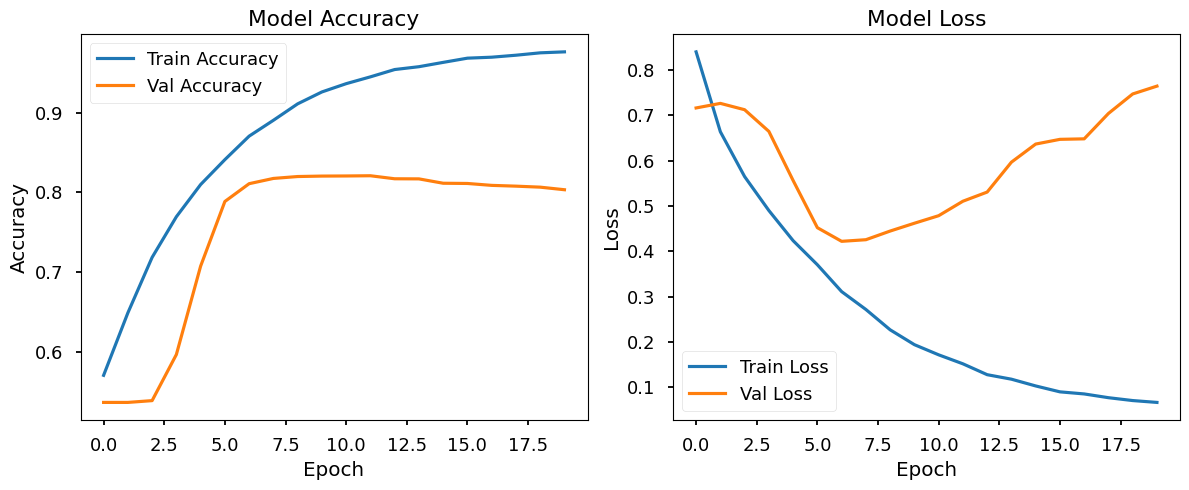

In [144]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm_GloVe.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_GloVe.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm_GloVe.history['loss'], label='Train Loss')
plt.plot(history_lstm_GloVe.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()